# Import libraries 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# These many images will be used from the data archive
dataset_split = 2500

master_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'
x = []
y = []

for image_file in os.listdir(master_dir)[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

# Train-test splitting

In [3]:
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )


dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )

In [4]:
test_x.shape

(250, 120, 120, 1)

In [5]:
train_x.shape

(2250, 120, 120, 1)

# Build Generator model

In [6]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model

# Build Discriminator model

In [7]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

# Loss Function

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train The GAN

In [9]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator(input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator(real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [10]:
# Number of epochs
num_epochs = 150

# Initialize lists to track loss and accuracy
generator_losses = []
discriminator_losses = []

for e in range(num_epochs):
    print(f"Epoch {e+1}/{num_epochs}")
    
    # Create a tqdm progress bar for the dataset
    with tqdm(total=len(dataset), desc=f"Epoch {e+1}/{num_epochs}") as pbar:
        for (x, y) in dataset:
            # Perform a training step and calculate loss
            train_step(x, y)

            # Optionally, you can compute loss here to display in tqdm
            generated_images = generator(x, training=True)
            real_output = discriminator(y, training=True)
            generated_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(generated_images, y)
            disc_loss = discriminator_loss(real_output, generated_output)
            
            # Update tqdm with generator and discriminator loss
            generator_losses.append(gen_loss.numpy())
            discriminator_losses.append(disc_loss.numpy())
            pbar.set_postfix({
                "gen_loss": f"{gen_loss.numpy():.4f}",
                "disc_loss": f"{disc_loss.numpy():.4f}"
            })
            pbar.update(1)


Epoch 1/150


Epoch 1/150: 100%|██████████| 36/36 [01:51<00:00,  3.11s/it, gen_loss=0.0237, disc_loss=0.9058]


Epoch 2/150


Epoch 2/150: 100%|██████████| 36/36 [01:09<00:00,  1.93s/it, gen_loss=0.0154, disc_loss=0.4191]


Epoch 3/150


Epoch 3/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0120, disc_loss=0.4834]


Epoch 4/150


Epoch 4/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0103, disc_loss=0.4377]


Epoch 5/150


Epoch 5/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0092, disc_loss=0.8909]


Epoch 6/150


Epoch 6/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0084, disc_loss=0.7284]


Epoch 7/150


Epoch 7/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0081, disc_loss=1.2418]


Epoch 8/150


Epoch 8/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0075, disc_loss=1.0967]


Epoch 9/150


Epoch 9/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0071, disc_loss=1.0331]


Epoch 10/150


Epoch 10/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0068, disc_loss=0.7975]


Epoch 11/150


Epoch 11/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0065, disc_loss=0.8063]


Epoch 12/150


Epoch 12/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0063, disc_loss=0.7317]


Epoch 13/150


Epoch 13/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0059, disc_loss=0.4938]


Epoch 14/150


Epoch 14/150: 100%|██████████| 36/36 [01:08<00:00,  1.92s/it, gen_loss=0.0061, disc_loss=0.6465]


Epoch 15/150


Epoch 15/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0056, disc_loss=0.6218]


Epoch 16/150


Epoch 16/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0055, disc_loss=0.5264]


Epoch 17/150


Epoch 17/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0054, disc_loss=0.4971]


Epoch 18/150


Epoch 18/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0053, disc_loss=1.0743]


Epoch 19/150


Epoch 19/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0055, disc_loss=0.6792]


Epoch 20/150


Epoch 20/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0049, disc_loss=0.6405]


Epoch 21/150


Epoch 21/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0048, disc_loss=0.5866]


Epoch 22/150


Epoch 22/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0048, disc_loss=0.6960]


Epoch 23/150


Epoch 23/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0047, disc_loss=0.5801]


Epoch 24/150


Epoch 24/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0046, disc_loss=0.5361]


Epoch 25/150


Epoch 25/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.6410]


Epoch 26/150


Epoch 26/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.7596]


Epoch 27/150


Epoch 27/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5251]


Epoch 28/150


Epoch 28/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.6242]


Epoch 29/150


Epoch 29/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.4965]


Epoch 30/150


Epoch 30/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.5049]


Epoch 31/150


Epoch 31/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0046, disc_loss=0.4408]


Epoch 32/150


Epoch 32/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0046, disc_loss=0.5108]


Epoch 33/150


Epoch 33/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0046, disc_loss=0.7010]


Epoch 34/150


Epoch 34/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5430]


Epoch 35/150


Epoch 35/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0045, disc_loss=0.4917]


Epoch 36/150


Epoch 36/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4583]


Epoch 37/150


Epoch 37/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5272]


Epoch 38/150


Epoch 38/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.5607]


Epoch 39/150


Epoch 39/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4199]


Epoch 40/150


Epoch 40/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.4138]


Epoch 41/150


Epoch 41/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5180]


Epoch 42/150


Epoch 42/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.6287]


Epoch 43/150


Epoch 43/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4355]


Epoch 44/150


Epoch 44/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4678]


Epoch 45/150


Epoch 45/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5074]


Epoch 46/150


Epoch 46/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.5234]


Epoch 47/150


Epoch 47/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0044, disc_loss=0.4707]


Epoch 48/150


Epoch 48/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4118]


Epoch 49/150


Epoch 49/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4214]


Epoch 50/150


Epoch 50/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4352]


Epoch 51/150


Epoch 51/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.3773]


Epoch 52/150


Epoch 52/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0043, disc_loss=0.4741]


Epoch 53/150


Epoch 53/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.3783]


Epoch 54/150


Epoch 54/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0043, disc_loss=0.4076]


Epoch 55/150


Epoch 55/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0042, disc_loss=0.4517]


Epoch 56/150


Epoch 56/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0042, disc_loss=0.5090]


Epoch 57/150


Epoch 57/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0042, disc_loss=0.4139]


Epoch 58/150


Epoch 58/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0042, disc_loss=0.4196]


Epoch 59/150


Epoch 59/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0042, disc_loss=0.4058]


Epoch 60/150


Epoch 60/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0041, disc_loss=0.3957]


Epoch 61/150


Epoch 61/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0042, disc_loss=0.3613]


Epoch 62/150


Epoch 62/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0042, disc_loss=0.3916]


Epoch 63/150


Epoch 63/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0041, disc_loss=0.4568]


Epoch 64/150


Epoch 64/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0041, disc_loss=0.4793]


Epoch 65/150


Epoch 65/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0041, disc_loss=0.4018]


Epoch 66/150


Epoch 66/150: 100%|██████████| 36/36 [01:08<00:00,  1.92s/it, gen_loss=0.0040, disc_loss=0.4338]


Epoch 67/150


Epoch 67/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0041, disc_loss=0.4389]


Epoch 68/150


Epoch 68/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0040, disc_loss=0.3933]


Epoch 69/150


Epoch 69/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0040, disc_loss=0.3729]


Epoch 70/150


Epoch 70/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0039, disc_loss=0.4158]


Epoch 71/150


Epoch 71/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0040, disc_loss=0.4124]


Epoch 72/150


Epoch 72/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0040, disc_loss=0.3342]


Epoch 73/150


Epoch 73/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0038, disc_loss=0.4504]


Epoch 74/150


Epoch 74/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0038, disc_loss=0.4119]


Epoch 75/150


Epoch 75/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0039, disc_loss=0.3928]


Epoch 76/150


Epoch 76/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0039, disc_loss=0.4111]


Epoch 77/150


Epoch 77/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0038, disc_loss=0.5300]


Epoch 78/150


Epoch 78/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0037, disc_loss=0.3855]


Epoch 79/150


Epoch 81/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0037, disc_loss=0.4156]


Epoch 82/150


Epoch 82/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0038, disc_loss=0.4306]


Epoch 83/150


Epoch 83/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0036, disc_loss=0.3811]


Epoch 84/150


Epoch 84/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0037, disc_loss=0.3687]


Epoch 85/150


Epoch 85/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0036, disc_loss=0.4036]


Epoch 86/150


Epoch 86/150: 100%|██████████| 36/36 [01:09<00:00,  1.92s/it, gen_loss=0.0037, disc_loss=0.4420]


Epoch 87/150


Epoch 87/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0036, disc_loss=0.3377]


Epoch 88/150


Epoch 88/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0036, disc_loss=0.4597]


Epoch 89/150


Epoch 89/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0036, disc_loss=0.3526]


Epoch 90/150


Epoch 90/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0036, disc_loss=0.4224]


Epoch 91/150


Epoch 91/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0035, disc_loss=0.4613]


Epoch 92/150


Epoch 92/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0035, disc_loss=0.4574]


Epoch 93/150


Epoch 93/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0035, disc_loss=0.4208]


Epoch 94/150


Epoch 94/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0035, disc_loss=0.3394]


Epoch 95/150


Epoch 95/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0035, disc_loss=0.3659]


Epoch 96/150


Epoch 96/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0034, disc_loss=0.4155]


Epoch 97/150


Epoch 97/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0034, disc_loss=0.3788]


Epoch 98/150


Epoch 98/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0034, disc_loss=0.4786]


Epoch 99/150


Epoch 99/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0034, disc_loss=0.4099]


Epoch 100/150


Epoch 100/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0034, disc_loss=0.3463]


Epoch 101/150


Epoch 101/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0033, disc_loss=0.3569]


Epoch 102/150


Epoch 102/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0033, disc_loss=0.4067]


Epoch 103/150


Epoch 103/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0033, disc_loss=0.4259]


Epoch 104/150


Epoch 104/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0032, disc_loss=0.4329]


Epoch 105/150


Epoch 105/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0033, disc_loss=0.3693]


Epoch 106/150


Epoch 106/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0032, disc_loss=0.3910]


Epoch 107/150


Epoch 107/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0033, disc_loss=0.4410]


Epoch 108/150


Epoch 108/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0031, disc_loss=0.4979]


Epoch 109/150


Epoch 109/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0032, disc_loss=0.3936]


Epoch 110/150


Epoch 110/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0032, disc_loss=0.3888]


Epoch 111/150


Epoch 111/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0032, disc_loss=0.3982]


Epoch 112/150


Epoch 112/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0031, disc_loss=0.3794]


Epoch 113/150


Epoch 113/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4579]


Epoch 114/150


Epoch 114/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.3568]


Epoch 115/150


Epoch 115/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.3613]


Epoch 116/150


Epoch 116/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.4536]


Epoch 117/150


Epoch 117/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.4103]


Epoch 118/150


Epoch 118/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.3723]


Epoch 119/150


Epoch 119/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4399]


Epoch 120/150


Epoch 120/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.4142]


Epoch 121/150


Epoch 121/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.4124]


Epoch 122/150


Epoch 122/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4366]


Epoch 123/150


Epoch 123/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4598]


Epoch 124/150


Epoch 124/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0031, disc_loss=0.4862]


Epoch 125/150


Epoch 125/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.3568]


Epoch 126/150


Epoch 126/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.3447]


Epoch 127/150


Epoch 127/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.3803]


Epoch 128/150


Epoch 128/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4257]


Epoch 129/150


Epoch 129/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0030, disc_loss=0.4022]


Epoch 130/150


Epoch 130/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0029, disc_loss=0.4066]


Epoch 131/150


Epoch 131/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0028, disc_loss=0.3456]


Epoch 132/150


Epoch 132/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0028, disc_loss=0.3892]


Epoch 133/150


Epoch 133/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0028, disc_loss=0.4131]


Epoch 134/150


Epoch 134/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.3921]


Epoch 135/150


Epoch 135/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0028, disc_loss=0.4114]


Epoch 136/150


Epoch 136/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.4397]


Epoch 137/150


Epoch 137/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.4262]


Epoch 138/150


Epoch 138/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.4319]


Epoch 139/150


Epoch 139/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.4029]


Epoch 140/150


Epoch 140/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.3674]


Epoch 141/150


Epoch 141/150: 100%|██████████| 36/36 [01:08<00:00,  1.90s/it, gen_loss=0.0027, disc_loss=0.4369]


Epoch 142/150


Epoch 142/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.3894]


Epoch 143/150


Epoch 143/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.3645]


Epoch 144/150


Epoch 144/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.3249]


Epoch 145/150


Epoch 145/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.4106]


Epoch 146/150


Epoch 146/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.3625]


Epoch 147/150


Epoch 147/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.3937]


Epoch 148/150


Epoch 148/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0027, disc_loss=0.4383]


Epoch 149/150


Epoch 149/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.3569]


Epoch 150/150


Epoch 150/150: 100%|██████████| 36/36 [01:08<00:00,  1.91s/it, gen_loss=0.0026, disc_loss=0.4522]


# Save Models

In [11]:
tf.keras.models.save_model(generator, 'generator_model.h5')
tf.keras.models.save_model(discriminator, 'discriminator_model.h5')

In [12]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 116, 116,  │        416 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 116, 116,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 114, 114,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 114, 114,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      9,248 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 108, 108,  │     25,632 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 108, 108,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 106, 106,  │     18,496 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 106, 106,  │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 104, 104,  │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 104, 104,  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │    102,464 │ leaky_re_lu_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 100, 100,  │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 98, 98,    │     73,856 │ leaky_re_lu_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 98, 98,    │          0 │ conv2d_7[0][0]  

 Total params: 1,406,403 (5.37 MB)

 Trainable params: 1,406,403 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 114, 114, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 108, 108, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 46, 46, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,907,905 (7.28 MB)

 Trainable params: 1,907,905 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

# Display the original and generated images side by side

In [14]:
# Define a batch size
batch_size = 32  # Adjust the batch size depending on GPU memory

# Process the input in smaller batches and generate images
generated_images = []
for i in range(0, len(test_x), batch_size):
    x_batch = test_x[i:i+batch_size]
    y_batch = generator(x_batch).numpy()  # Generate images
    generated_images.append(y_batch)

# Combine all generated images
generated_images = np.concatenate(generated_images, axis=0)

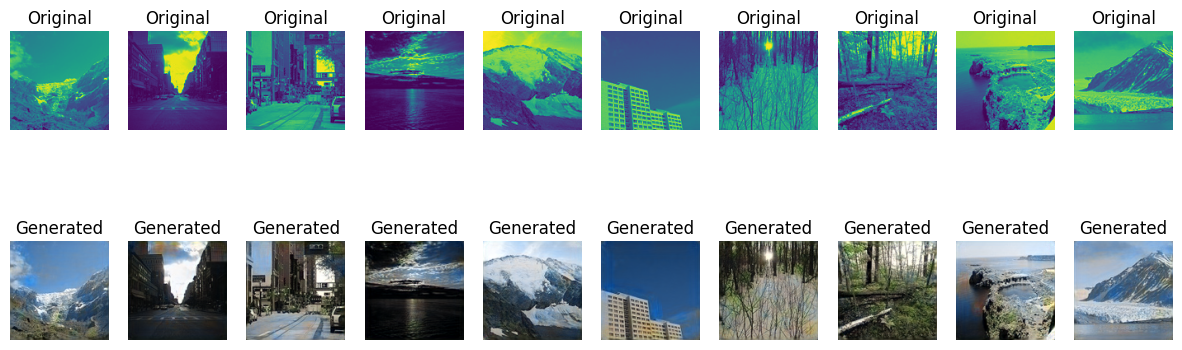

In [15]:
def plot_before_after(original_images, generated_images, num_images=10):
    plt.figure(figsize=(15, 5))  # Adjust figure size to fit images
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])  # Original image
        plt.axis('off')
        plt.title('Original')

        # Display generated image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])  # Generated image
        plt.axis('off')
        plt.title('Generated')

    plt.show()

# Display the first 10 images before and after generation
plot_before_after(test_x, generated_images, num_images=10)


# Load and preprocess your own image (convert to grayscale)

In [19]:
def load_and_preprocess_image(image_path, target_size=(120, 120)):
    image = tf.io.read_file(image_path)  # Read the image file
    image = tf.image.decode_png(image, channels=3)  # Decode as PNG (for PNG files)
    image = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale
    image = tf.image.resize(image, target_size)  # Resize the image to the target size
    image = image / 255.0  # Normalize the image to [0, 1]
    return image

# Path to your own image (adjust the path as needed)
image_path = '/kaggle/input/own-test-photo/horse.png'

# Load and preprocess the image
original_image = load_and_preprocess_image(image_path)

# Add a batch dimension to make it compatible with the generator
input_image = tf.expand_dims(original_image, axis=0)

# Generate the image using your model (ensure the generator is loaded and ready)
generated_image = generator(input_image).numpy()[0]  # Remove batch dimension


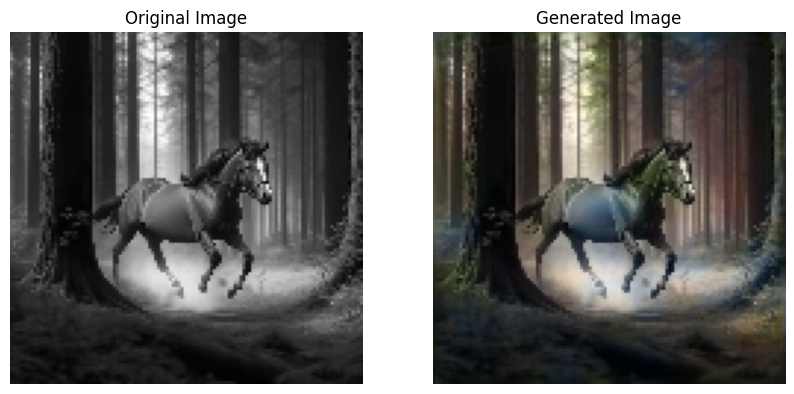

In [20]:
# Display the original and generated image side by side
def plot_before_after(original_image, generated_image):
    plt.figure(figsize=(10, 5))  # Adjust figure size
    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(original_image), cmap='gray')  # Use tf.squeeze to remove dimensions
    plt.axis('off')
    plt.title('Original Image')

    # Display generated image
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(generated_image), cmap='gray')  # Use tf.squeeze to remove dimensions
    plt.axis('off')
    plt.title('Generated Image')

    plt.show()

# Display the original and generated images
plot_before_after(original_image, generated_image)